In [ ]:
#install apache-spark
#install java
#https://github.com/pj201/cc-analysis

# Launch this notebook with the following command to enable graphFrames:
#  %pyspark --packages graphframes:graphframes:0.5.0-spark2.1-s_2.11 --num-executors 3 --driver-memory 3g --executor-memory 3g
# and add the following two lines to your ~/.bashrc:
#  export PYSPARK_DRIVER_PYTHON=jupyter
#  export PYSPARK_DRIVER_PYTHON_OPTS='notebook'
#
# Pre-requisite to running this notebook - construct a graph using cc-pyspark example code as follows:
#  git clone https://github.com/commoncrawl/cc-pyspark.git
#  cd cc-pyspark
# ./get-data.sh

In [1]:
!pip install langdetect
#!pip install nltk

    100% |████████████████████████████████| 1.0MB 689kB/s eta 0:00:01
  Running setup.py bdist_wheel for langdetect ... done
  Stored in directory: /Users/tommys/Library/Caches/pip/wheels/6f/8c/3b/ffa8151e27effd7de2a7d3194650d78fe6e4d4a3c175a74867
Successfully built langdetect


# Read WET archives

In [2]:
import argparse
import logging
import os
import re

from tempfile import TemporaryFile

import boto3
import botocore

from warcio.archiveiterator import ArchiveIterator
from warcio.recordloader import ArchiveLoadFailed

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, LongType

from urllib.parse import urlparse
from langdetect import detect_langs

def detect(x):
    try:
        return detect_langs(x[:300])[0].lang
    except Exception as e:
        return None

def process_warcs(id_, iterator):
    s3pattern = re.compile('^s3://([^/]+)/(.+)')
    base_dir = os.path.abspath(os.path.dirname('cc-pyspark/'))

    # S3 client (not thread-safe, initialize outside parallelized loop)
    no_sign_request = botocore.client.Config(
        signature_version=botocore.UNSIGNED)
    s3client = boto3.client('s3', config=no_sign_request)

    for uri in iterator:
        if uri.startswith('s3://'):
            s3match = s3pattern.match(uri)
            if s3match is None:
                continue
            bucketname = s3match.group(1)
            path = s3match.group(2)
            warctemp = TemporaryFile(mode='w+b',
                                     dir=None)
            try:
                s3client.download_fileobj(bucketname, path, warctemp)
            except botocore.client.ClientError as exception:
                continue
            warctemp.seek(0)
            stream = warctemp
        elif uri.startswith('hdfs://'):
            continue
        else:
            if uri.startswith('file:'):
                uri = uri[5:]
            uri = os.path.join(base_dir, uri)
            try:
                stream = open(uri, 'rb')
            except IOError as exception:
                continue

        no_parse = (not True)
        try:
            for record in ArchiveIterator(stream,no_record_parse=no_parse):
                url = record.rec_headers.get_header('WARC-Target-URI')
                domain = None if not url  else urlparse(url).netloc
                text = record.content_stream().read().decode('utf-8')
                lang = detect(text)
                yield domain, url, lang, text
        except ArchiveLoadFailed as exception:
            continue

In [24]:
from os.path import abspath
import glob

input_data = sc.parallelize(['file:'+abspath(f) for f in glob.glob("crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/*")])

In [25]:
input_data.take(10)

['file:/Users/tommys/crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/CC-MAIN-20170322212946-00000-ip-10-233-31-227.ec2.internal.warc.wet.gz',
 'file:/Users/tommys/crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/CC-MAIN-20170322212946-00001-ip-10-233-31-227.ec2.internal.warc.wet.gz',
 'file:/Users/tommys/crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/CC-MAIN-20170322212946-00002-ip-10-233-31-227.ec2.internal.warc.wet.gz',
 'file:/Users/tommys/crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/CC-MAIN-20170322212946-00003-ip-10-233-31-227.ec2.internal.warc.wet.gz',
 'file:/Users/tommys/crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/CC-MAIN-20170322212946-00004-ip-10-233-31-227.ec2.internal.warc.wet.gz']

In [27]:
#input_data = sc.textFile('cc-pyspark/input/test_wet.txt', minPartitions=400)

output = input_data.mapPartitionsWithIndex(process_warcs)

In [28]:
docs = output.toDF(["domain", "url", "lang", "text"])
docs.cache()

DataFrame[domain: string, url: string, lang: string, text: string]

In [31]:
list(map(int,k.split()))

[2, 12]

In [29]:
%%time
docs.show()

+--------------------+--------------------+----+--------------------+
|              domain|                 url|lang|                text|
+--------------------+--------------------+----+--------------------+
|                null|                null|  en|Software-Info: ia...|
|00ena00.blog.fc2.com|http://00ena00.bl...|  ja|～たまに撮れる瞬間を求めて～ SL...|
|00pon00.blog130.f...|http://00pon00.bl...|  ja|せれぶもどきな午後 ☆プディング☆...|
|        03online.com|http://03online.c...|  ru|Движение под коже...|
|        03online.com|http://03online.c...|  ru|Насморк при берем...|
|        03online.com|http://03online.c...|  ru|Помогите пожалуйс...|
|        03online.com|http://03online.c...|  ru|Пью много воды за...|
|        03online.com|http://03online.c...|  ru|Жёлтая кожа лица ...|
|            08.od.ua|http://08.od.ua/n...|  ru|Тв-дом, телевизио...|
|            08.od.ua|http://08.od.ua/o...|  ru|Дюковский, рестор...|
|            08.od.ua|http://08.od.ua/p...|  ru|Paolo conte, мага...|
|            08.od.u

In [30]:
docs.count()

227444

# How many domains have an index.html?

In [10]:
s = docs.filter("url LIKE '%index.html'").groupby('domain').count().toPandas()

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


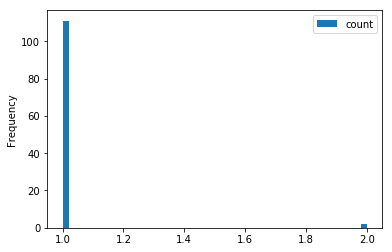

In [14]:
s.plot.hist(bins=50)

In [22]:
docs.select("domain").distinct().count()

30769

In [31]:
docs.select("domain").distinct().count()

94630

In [10]:
from pyspark.sql import functions as F

docs.groupby("domain").aggregate(F.array_contains('url','index.html') else False)

AttributeError: 'GroupedData' object has no attribute 'aggregate'

In [8]:
g.agg?

# What proportions of languages do we get?

In [32]:
langs = docs.groupby("lang").count().toPandas().sort_values('count', ascending=False).set_index('lang')

In [33]:
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


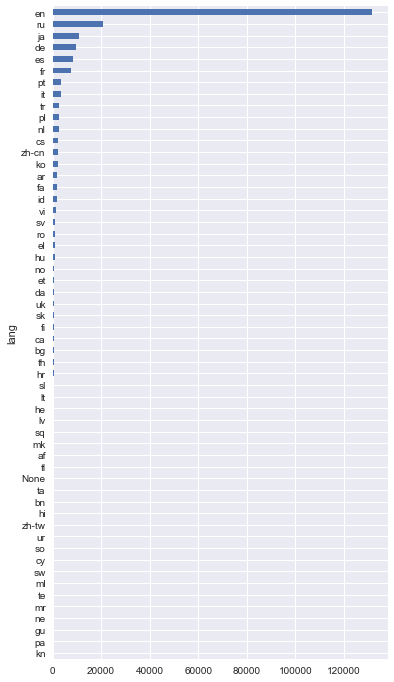

In [34]:
%pylab inline
import pandas as pd

langs['count'][::-1].plot(kind='barh', figsize=(6,12))

# How many pages per domain?

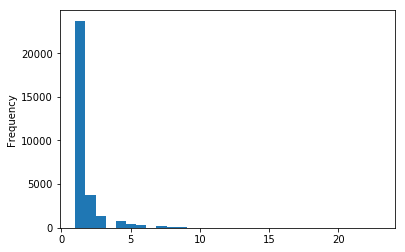

In [15]:
docs.groupby("domain").count().toPandas()['count'].plot.hist(bins=30)

# Filter to English Pages

In [35]:
docs_en = docs.filter(docs.lang == 'en')

In [36]:
docs_en.count()

131451

# Sample text per domain

* Select index.html
* Select 5 random pages and concat text

In [ ]:
docs_en.groupby('domain')


# Text Processing Pipeline

In [37]:
#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
stopwords_english = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StopWordsRemover

tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\p{L}+", gaps=False)
stopwordRemover = StopWordsRemover(inputCol="words", outputCol="filtered",stopWords=stopwords_english, caseSensitive=False)
cv = CountVectorizer(inputCol="filtered", outputCol="vec",vocabSize=20000, minDF=50)

pipeline = Pipeline(stages=[tokenizer, stopwordRemover, cv])

In [39]:
#docs = rdd.sample(True,0.1).toDF(["docId", "text"])
model = pipeline.fit(docs_en)


# Convert to mllib sparse vectors for compatibility with LDA
#from pyspark.mllib.linalg import SparseVector

#def fromMl(v1):
#    v1d = dict(zip(v1.indices, v1.values))
#    return SparseVector(v1.size, v1d)

#corpus = vecs.select("vec").rdd.zipWithIndex().map(lambda x: [x[1],fromMl(x[0].vec)])

In [40]:
vecs = model.transform(docs_en)

# Size of vectors vs original data

In [41]:
vecs2=vecs.drop('text').drop('words').drop('filtered')
vecs2.write.parquet('cc_sample_vecs.parquet')

In [43]:
!du -h cc_sample_vecs.parquet

 89M	cc_sample_vecs.parquet


In [65]:
!du -h crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/

148M	crawl-data/CC-MAIN-2017-13/segments/1490218186353.38/wet/


# LDA Training

In [44]:
%%time

from pyspark.ml.clustering import LDA
#inputCol="vec", outputCol="ldaVec", k=3, optimizer="online"

lda = LDA(k=10, maxIter=20, featuresCol="vec")

ldaModel = lda.fit(vecs)

CPU times: user 175 ms, sys: 76.6 ms, total: 252 ms
Wall time: 31min 33s


In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [99]:
ldaModel.describeTopics(maxTermsPerTopic = 50).collect()[0][0]

0

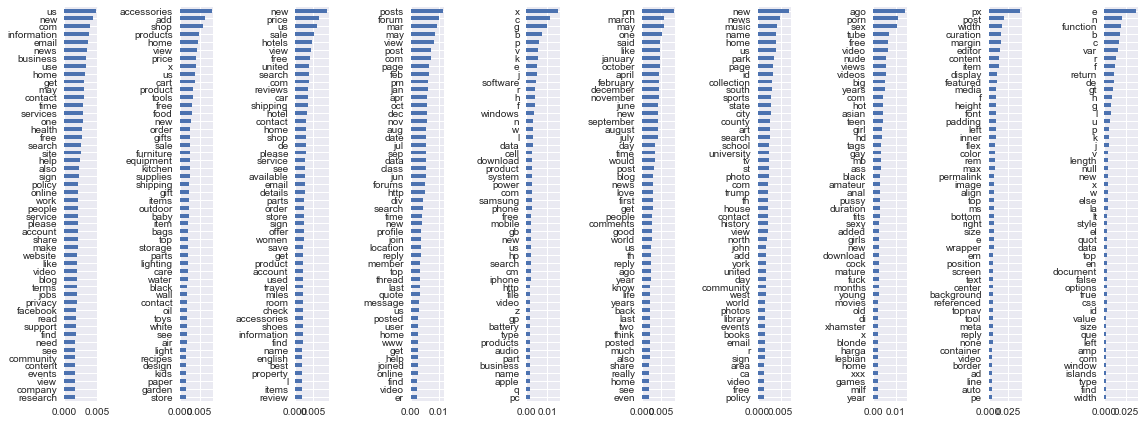

In [45]:
import pandas as pd
topicIndices = ldaModel.describeTopics(maxTermsPerTopic = 50).collect()
vocab = model.stages[2].vocabulary

fig,axes = np.array(plt.subplots(nrows=1,ncols=10, figsize=(16,6))).ravel()

for i, (topic, terms, termWeights) in enumerate(topicIndices):
    ax=axes[i]
    topwords = pd.Series(dict(zip([vocab[t] for t in terms], termWeights))).sort_values()
    topwords.plot(kind='barh', ax=ax)
    
plt.tight_layout()

In [46]:
vecs_sample = vecs.sample(True,0.1)

In [ ]:
vecs_sample.take(2)

In [47]:
results = ldaModel.transform(vecs_sample)
topic_vectors = results.rdd.map(lambda x: x.topicDistribution).collect()
X=np.array(topic_vectors)

In [23]:
X.shape

(4463, 10)

In [48]:
sample_langs = vecs_sample.rdd.map(lambda x: x.lang).collect()

In [49]:
toplangs = set(pd.Series(sample_langs).value_counts().head().index.values.tolist())

In [50]:
sample_langs2 = np.array([l if l in toplangs else 'other' for l in sample_langs])

# TSNE

In [51]:
from sklearn.manifold import TSNE

tsne_results = []
for p in [30,50,100]:
    tsne = TSNE(perplexity=p)
    X2 = tsne.fit_transform(X)
    tsne_results.append((tsne, X2))
    print('done')

done
done
done


In [52]:
pal=sns.color_palette("Paired",10)

In [53]:
primary_topic = np.argmax(X,axis=1)

In [54]:
colour=[pal[c] for c in primary_topic]

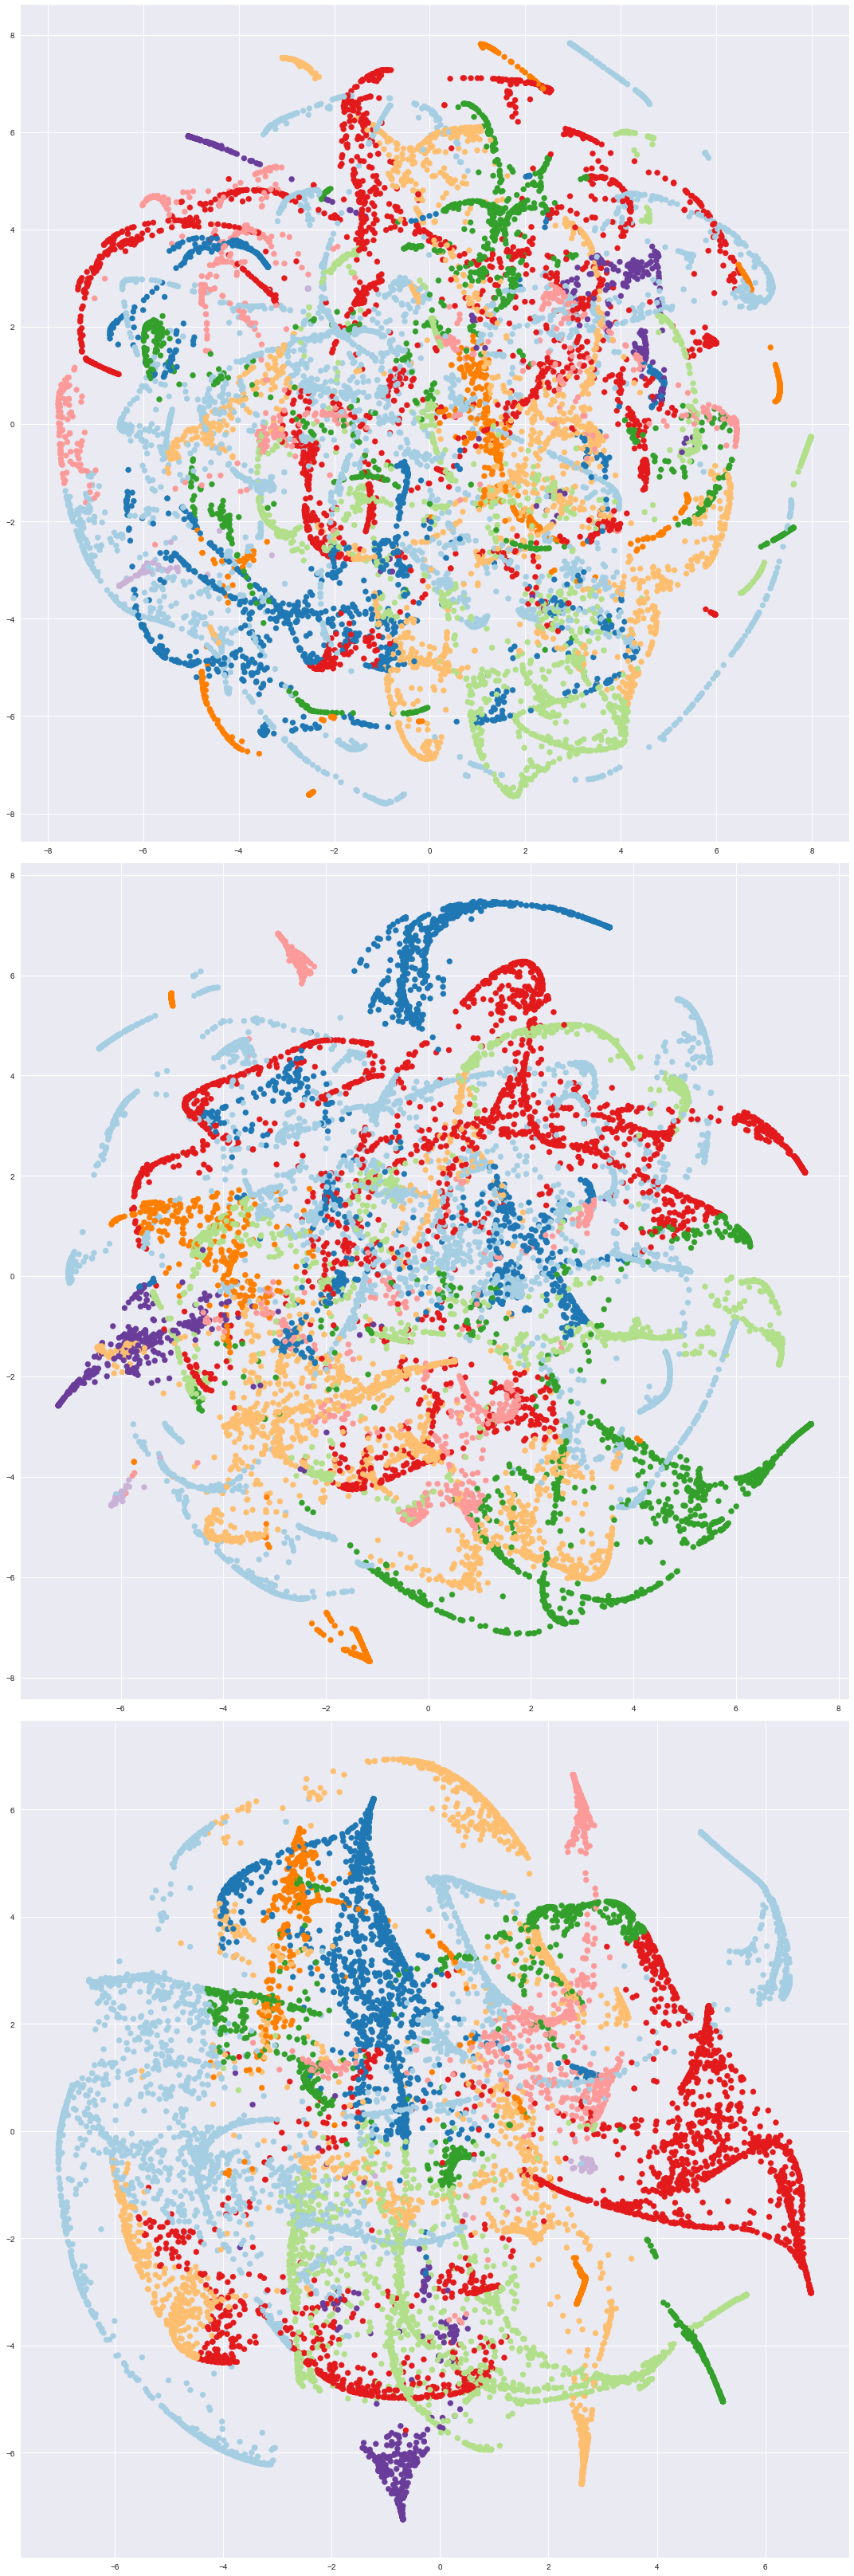

In [57]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(15,45))

for (tsne,X2),ax in zip(tsne_results,axes.ravel()):
    ax.scatter(X2[:,0],X2[:,1],c=colour)
    #ax.axis('off')
plt.tight_layout()

# Coloured by primary topic

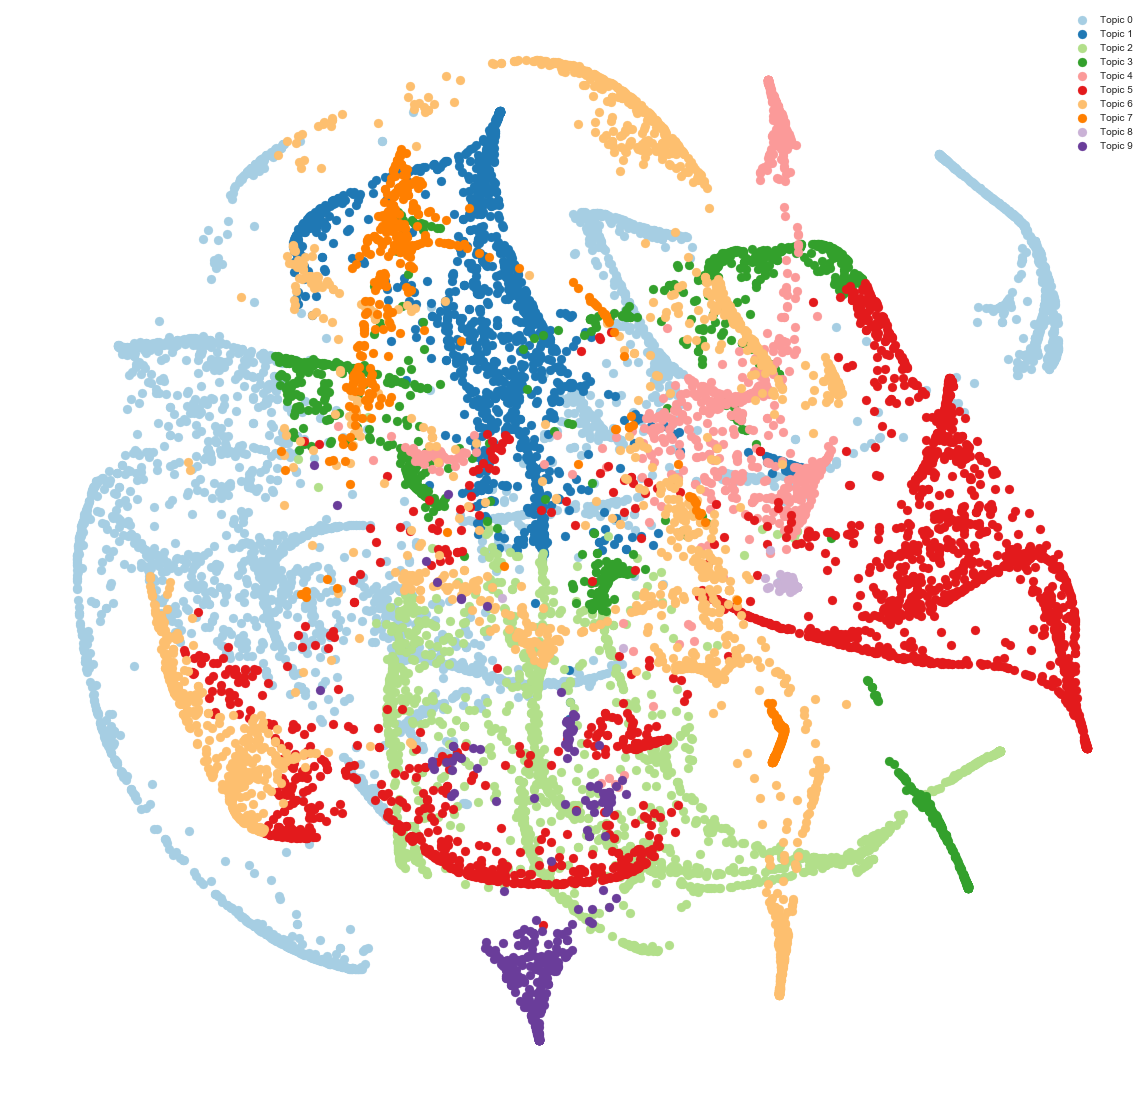

In [58]:
X2 = tsne_results[2][1]
plt.figure(figsize=(20,20))

for i in range(10):
    X3 = X2[np.argwhere(primary_topic==i)].reshape(-1,2)
    plt.scatter(X3[:,0],X3[:,1], c=pal[i], label='Topic {}'.format(i),s=80)
plt.axis('off')
plt.legend()

In [59]:
plotlangs = pd.Series(sample_langs).value_counts().head().index.values.tolist() + ['other']

In [60]:
plotlangs

['en', 'other']

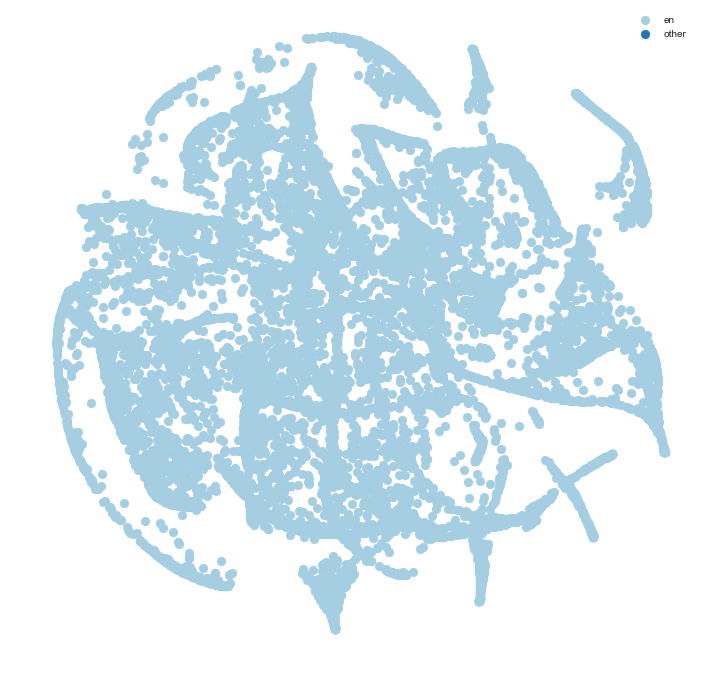

In [61]:
X2 = tsne_results[2][1]
plt.figure(figsize=(12,12))

for i in range(len(plotlangs)):
    X3 = X2[np.argwhere(sample_langs2==plotlangs[i])].reshape(-1,2)
    plt.scatter(X3[:,0],X3[:,1], c=pal[i], label='{}'.format(plotlangs[i]), s=80)
plt.axis('off')
plt.legend()

# PyLDAVis

In [ ]:
!pip install pyldavis

# Domain Level TSNE

In [74]:
from pyspark.mllib.linalg import DenseVector


from pyspark.mllib.feature import Normalizer

norm = Normalizer(1)

domain_topic_vecs = results.select(['domain','topicDistribution']).rdd.mapValues(lambda v: v.toArray()) \
     .reduceByKey(lambda x, y: x + y) \
     .mapValues(lambda x: norm.transform(DenseVector(x))) \
     .toDF(["domain", "topicDistribution"])

In [76]:
topic_vectors = domain_topic_vecs.rdd.map(lambda x: x.topicDistribution).collect()
X=np.array(topic_vectors)

In [85]:
domain_topic_vecs.rdd.saveAsTextFile('ldavecs.txt')

In [79]:
tsne = TSNE(perplexity=100, init='pca')
X2 = tsne.fit_transform(X)

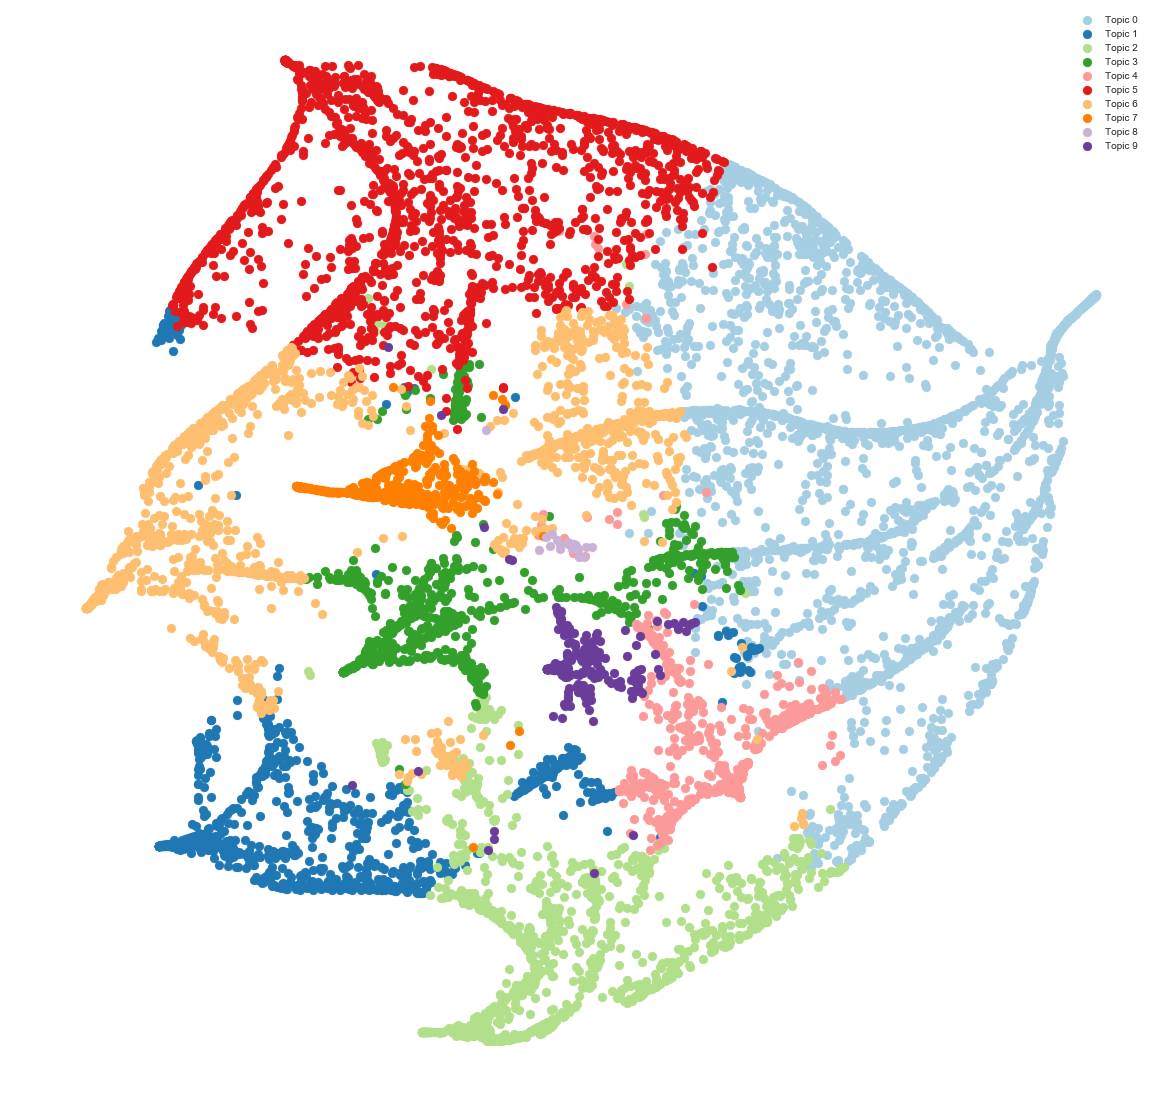

In [81]:
plt.figure(figsize=(20,20))

primary_topic = np.argmax(X,axis=1)

for i in range(10):
    X3 = X2[np.argwhere(primary_topic==i)].reshape(-1,2)
    plt.scatter(X3[:,0],X3[:,1], c=pal[i], label='Topic {}'.format(i),s=80)
plt.axis('off')
plt.legend()

# Save domain topic vecs

In [90]:
# WARNING don't use coalesce(1) with large data

domain_topic_vecs.select(['domain','topicDistribution']).rdd \
    .map(lambda v: (v.domain,v.topicDistribution.toArray())) \
    .coalesce(1) \
    .saveAsTextFile('ldavecs', 'org.apache.hadoop.io.compress.GzipCodec')

In [91]:
df = domain_topic_vecs.toPandas()
df2=pd.DataFrame(np.vstack(df.topicDistribution.apply(lambda x:x.toArray()).values), index=df.domain)